In [115]:
#These are the libaries we are using 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


df = pd.read_csv("UberDataset.csv")

print(df.head())



         START_DATE          END_DATE  CATEGORY        START             STOP  \
0  01-01-2016 21:11  01-01-2016 21:17  Business  Fort Pierce      Fort Pierce   
1  01-02-2016 01:25  01-02-2016 01:37  Business  Fort Pierce      Fort Pierce   
2  01-02-2016 20:25  01-02-2016 20:38  Business  Fort Pierce      Fort Pierce   
3  01-05-2016 17:31  01-05-2016 17:45  Business  Fort Pierce      Fort Pierce   
4  01-06-2016 14:42  01-06-2016 15:49  Business  Fort Pierce  West Palm Beach   

   MILES          PURPOSE  
0    5.1   Meal/Entertain  
1    5.0              NaN  
2    4.8  Errand/Supplies  
3    4.7          Meeting  
4   63.7   Customer Visit  


In [116]:
df.columns = df.columns.str.strip()

# Convert date columns to datetime format
df['START_DATE'] = pd.to_datetime(df['START_DATE'], errors='coerce')
df['END_DATE'] = pd.to_datetime(df['END_DATE'], errors='coerce')

# Drop rows with invalid dates
df.dropna(subset=['START_DATE', 'END_DATE'], inplace=True)

df['PURPOSE'].fillna('Unknown', inplace=True)

# Calculate trip duration in minutes
df['Trip_Duration'] = (df['END_DATE'] - df['START_DATE']).dt.total_seconds() / 60

df = df[df['Trip_Duration'] > 0]


df = pd.get_dummies(df, columns=['CATEGORY', 'START', 'STOP', 'PURPOSE'], drop_first=True)


print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151 entries, 0 to 1154
Columns: 378 entries, START_DATE to PURPOSE_Unknown
dtypes: datetime64[ns](2), float64(2), uint8(374)
memory usage: 465.3 KB
None


In [117]:
X = df.drop(columns=['START_DATE', 'END_DATE', 'MILES'])
y = df['MILES']

# Split the data into training and testing sets (80/20 split)
X_train_original, X_test_original, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train_original)
X_test = scaler.transform(X_test_original)

# Print the shapes of the datasets
print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")


Training data shape: (920, 375), Testing data shape: (231, 375)


In [118]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

# Evaluate Linear Regression Model
lr_mae, lr_mse, lr_rmse, lr_r2 = evaluate_model(lr_model, X_test, y_test)
print("Linear Regression Performance:")
print(f"MAE: {lr_mae:.2f}, MSE: {lr_mse:.2f}, RMSE: {lr_rmse:.2f}, R²: {lr_r2:.2f}")

# Evaluate Random Forest Model
rf_mae, rf_mse, rf_rmse, rf_r2 = evaluate_model(rf_model, X_test, y_test)
print("Random Forest Regression Performance:")
print(f"MAE: {rf_mae:.2f}, MSE: {rf_mse:.2f}, RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")

Linear Regression Performance:
MAE: 318818801855659.31, MSE: 1544083091692775037667314237440.00, RMSE: 1242611400113798.75, R²: -2063879820634538536985427968.00
Random Forest Regression Performance:
MAE: 4.91, MSE: 195.73, RMSE: 13.99, R²: 0.74


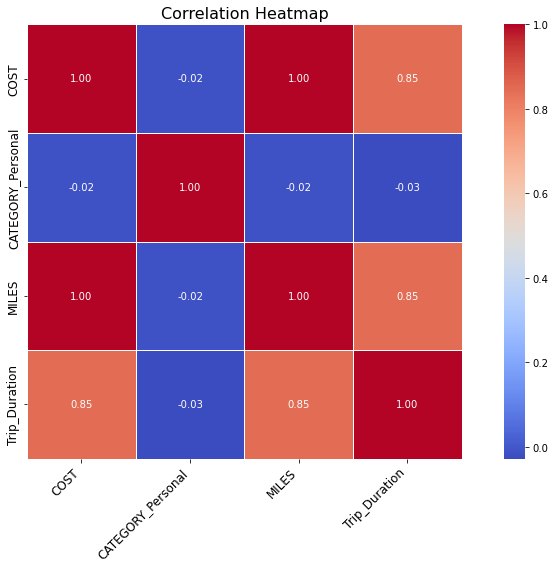

In [119]:
if 'COST' not in df.columns:
    df['COST'] = 0.5 * df['MILES'] + 2  

# Select relevant columns by excluding those that start with 'STOP' or 'START'
relevant_columns = [
    col for col in df.columns if not (col.startswith('STOP') or col.startswith('START') or col.startswith('PURPOSE'))
] 

# Remove duplicates if any (ensuring 'Trip_Duration', 'MILES', and 'COST' are only included once)
relevant_columns = list(set(relevant_columns))

# Compute the correlation matrix for the selected columns
correlation_matrix = df[relevant_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 10}  # Adjust annotation font size
)

# Customize labels and title
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(fontsize=12, rotation=45, ha="right")  # Rotate x-axis labels
plt.yticks(fontsize=12)  # Keep y-axis labels horizontal
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

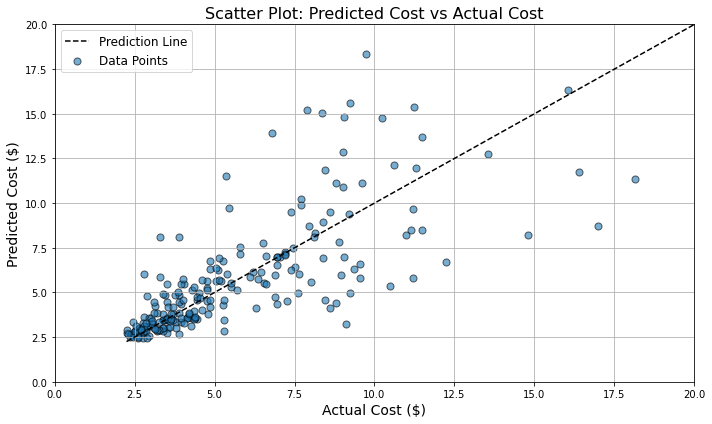

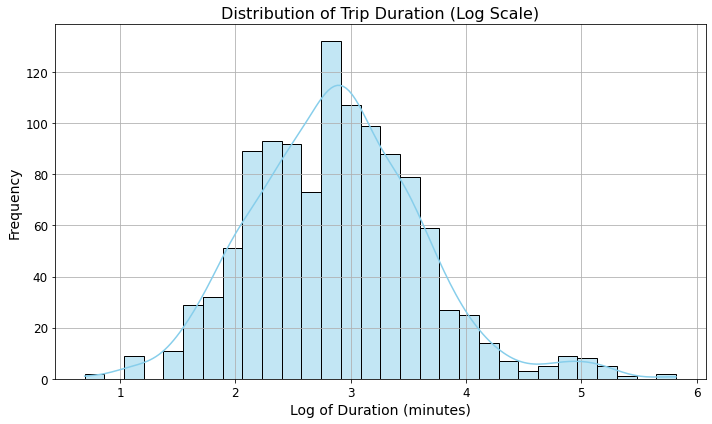

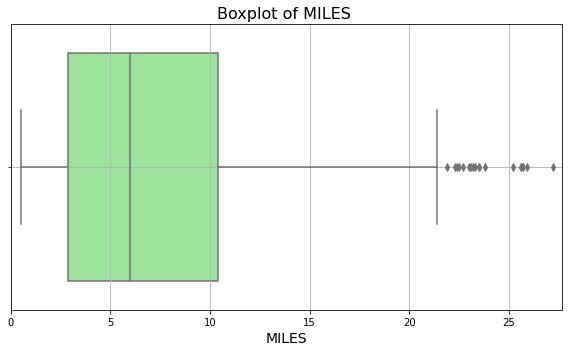

In [122]:
y_pred_rf = rf_model.predict(X_test)  # Predict miles using the model
predicted_cost = 0.5 * y_pred_rf + 2  # Example formula to derive predicted cost

# Extract actual costs from the test set
actual_cost = df.loc[X_test_original.index, 'COST']

# Scatter plot: Predicted Cost vs Actual Cost
plt.figure(figsize=(10, 6))
plt.scatter(actual_cost, predicted_cost, alpha=0.6, edgecolor='k', s=50, label="Data Points")

# Add a diagonal line to indicate perfect predictions
plt.plot([actual_cost.min(), actual_cost.max()], [actual_cost.min(), actual_cost.max()], 
         color='black', linestyle='--', label="Prediction Line")

# Set labels and title
plt.xlabel("Actual Cost ($)", fontsize=14)
plt.ylabel("Predicted Cost ($)", fontsize=14)
plt.title("Scatter Plot: Predicted Cost vs Actual Cost", fontsize=16)

# Add grid and legend
plt.grid(True)
plt.legend(fontsize=12)
plt.xlim(0, 20)  # Focus on actual costs between $0 and $20
plt.ylim(0, 20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['Trip_Duration']), bins=30, kde=True, color='skyblue')
plt.title("Distribution of Trip Duration (Log Scale)", fontsize=16)
plt.xlabel("Log of Duration (minutes)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
sns.boxplot(x=df['MILES'], color='lightgreen')
plt.title("Boxplot of MILES ", fontsize=16)
plt.xlabel("MILES", fontsize=14)
plt.xlim(0, df['MILES'].quantile(0.95))  
plt.grid(True)
plt.tight_layout()
plt.show()
